This notebook should be used for loading, preprocessing, segmenting, and extracting the crystallinity features of a single POM image.

## Loading a polarized optical microscope (POM) image

This section is for loading the raw POM image. The image is displayed with a scale bar matching the calibration of the lens ([Olympus LMPLFLN 10X Objective - Edmund Optics](https://www.edmundoptics.com/p/olympus-lmplfln-10x-objective/30478/)).  
Spatial calibration was such that 130 pixels are equivalent to 60 microns.


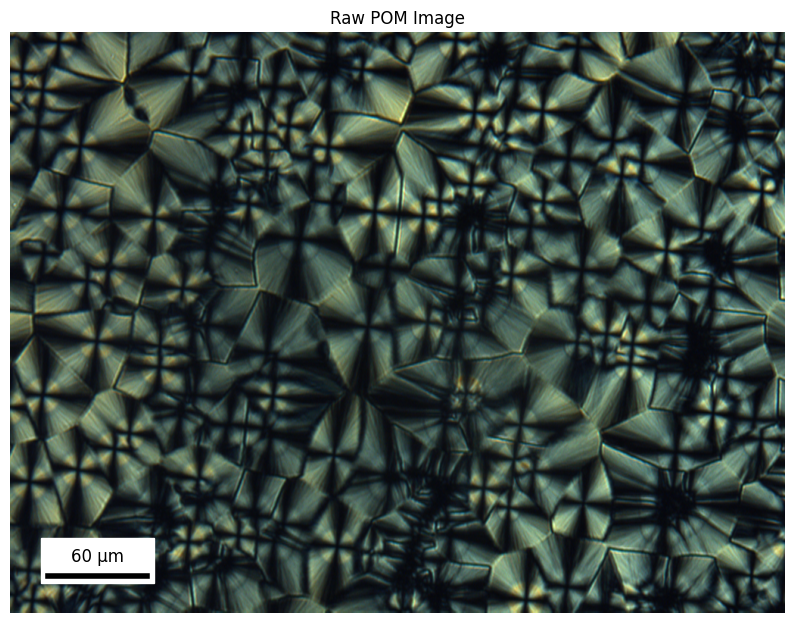

In [1]:
import sys
sys.path.append("../../src/data_loading")  # Ensure Python finds the module

import image_loader

# Define image path
image_path = "../../data/raw/S33.tif"

# Load the raw POM image
raw_image = image_loader.load_image(image_path)

# Display the POM image with a scale bar included
sys.path.append("../../src/visualization")  # Ensure Python finds the module
import image_with_scale_bar

image_with_scale_bar.display_image(raw_image, title = "Raw POM Image")


## Preprocessing the image

### **Preprocessing Steps Explained**

**_Overview_**  
The preprocessing stage is crucial for preparing the image for segmentation. It involves:  
1. Converting the image to grayscale  
2. Applying Gaussian blur to reduce noise  
3. Thresholding to create a binary image  
4. Morphological operations for noise removal  
5. Computing markers for watershed segmentation  

---

**_Convert to Grayscale_**  
**Why?**  
Many image processing techniques, especially thresholding and segmentation, work better on grayscale images because they rely on intensity values rather than color information.  

**What happens?**  
The image, originally in color format when loaded, is converted to grayscale. This simplifies the image from three color channels (Blue, Green, Red) to a single intensity channel, making it easier to process in later steps.  

- No parameters need adjustment for grayscale conversion.  

---

**_Apply Gaussian Blur_**  
**Why?**  
Blurring reduces noise and small variations in the image that might interfere with segmentation. It smooths intensity variations, making thresholding more effective.  

**Parameter to adjust:**  
- **Blur kernel size** determines the strength of blurring.  
  - Recommended values:  
    - *Small blur (3x3)*: Keeps fine details but may not remove noise effectively.  
    - *Medium blur (5x5)*: A balanced choice for most images.  
    - *Large blur (7x7 or more)*: Stronger smoothing, useful if noise is high but may blur fine structures.  

---

**_Apply Thresholding_**  
Thresholding converts a grayscale image into a binary image, which is crucial for segmentation.  

**Types of Thresholding:**  
- **Global Thresholding**: A fixed threshold is applied across the entire image. Pixels above the threshold become white, while those below become black.  
- **Adaptive Thresholding**: The algorithm calculates a local threshold for small regions, useful when lighting is uneven.  

**When to Use?**  
- Use *global thresholding* when the image has uniform lighting and contrast.  
- Use *adaptive thresholding* when lighting varies across the image.  

**Parameters to Adjust:**  
- **Threshold value (for global thresholding):**  
  - *Lower threshold (≤100)*: Captures more details but may introduce noise.  
  - *Medium threshold (120–150)*: A good starting point for most images.  
  - *Higher threshold (≥180)*: Retains only the brightest areas, useful when removing faint structures.  

- **Block size (for adaptive thresholding):**  
  - *Small block size (9–11)*: Preserves fine details but may introduce noise.  
  - *Medium block size (15–19)*: Works well for general cases.  
  - *Large block size (21+)*: Creates smoother regions, useful when lighting varies.  

- **Constant (C) subtracted from the mean:**  
  - *Smaller values (1–3)*: Keep more details.  
  - *Larger values (8–10)*: Make thresholding more strict, useful for reducing noise.  

---

**_Perform Morphological Operations (Noise Removal)_**  
**Why?**  
Small noise and artifacts may interfere with segmentation. Morphological operations enhance important structures while removing unwanted noise.  

**Operations Used:**  
1. **Opening**: Removes small bright spots (white noise) in the binary image.  
2. **Dilation**: Expands foreground objects to ensure proper segmentation.  

**Parameters to Adjust:**  
- **Kernel size**: Defines the size of the structuring element for these operations.  
  - Recommended values:  
    - *Small kernel (3x3)*: Preserves fine details but may leave noise in the image.  
    - *Medium kernel (5x5)*: A good balance between noise removal and detail preservation.  
    - *Large kernel (7x7 or more)*: Removes more noise but may erode small features.  

- **Number of iterations for dilation:**  
  - *Fewer iterations (1–2)*: Light expansion of objects.  
  - *More iterations (3–5)*: Stronger expansion, useful for separating connected regions.  

---

**_Compute Markers for Watershed Segmentation_**  
**Why?**  
The watershed algorithm requires labeled markers to distinguish different regions in an image. These markers help define:  
- **Sure foreground** (objects to be segmented).  
- **Sure background** (empty regions).  
- **Unknown regions** (boundaries between objects).  

**Steps to Compute Markers:**  
1. Find the sure foreground using distance transform.  
2. Find the unknown region by subtracting the foreground from the background.  
3. Label the different objects using connected components.  
4. Assign markers for watershed segmentation.  

**Parameter to Adjust:**  
- **Threshold for detecting foreground regions**  
  - Recommended values:  
    - *Lower threshold (0.3 × max distance transform)*: Captures more foreground details but may merge close objects.  
    - *Medium threshold (0.5 × max distance transform)*: A balanced choice for most images.  
    - *Higher threshold (0.7 × max distance transform)*: Detects only the strongest foreground regions.  

---

**_How to Modify Parameters Based on Image Type_**  

| **Scenario** | **Recommended Adjustments** |
|-------------|----------------------------|
| **Image has noise** | Increase blurring (kernel size *5x5* or larger), apply more noise removal operations (opening with *5x5* kernel). |
| **Objects are merging in segmentation** | Lower the threshold value (*100–120*), or increase the block size (*15+*) for adaptive thresholding. |
| **Small features are missing** | Reduce blurring (*3x3* kernel), decrease the constant (*C = 2–3*) in adaptive thresholding. |
| **Foreground is not well detected** | Adjust the foreground threshold (*0.3 × max distance transform* to *0.5 × max distance transform*). |
| **Uneven lighting** | Use adaptive thresholding with a larger block size (*21+*). |




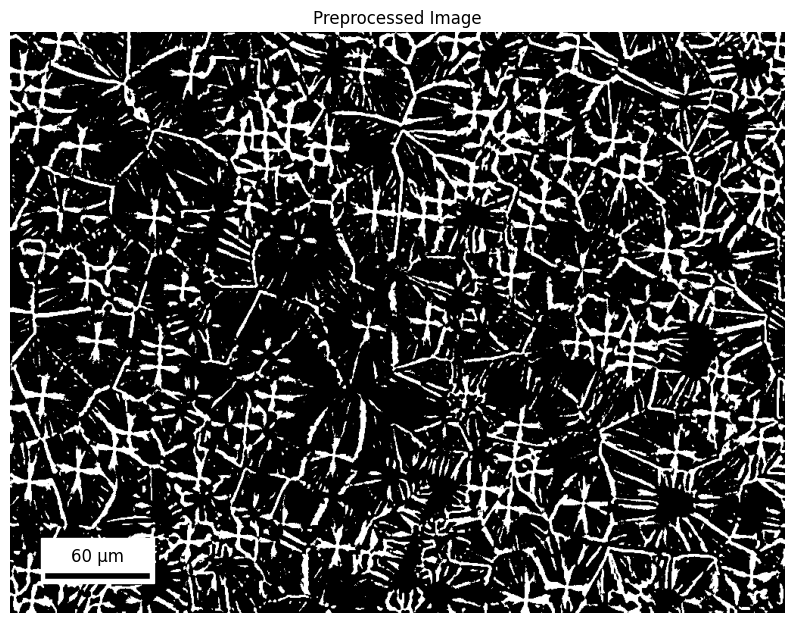

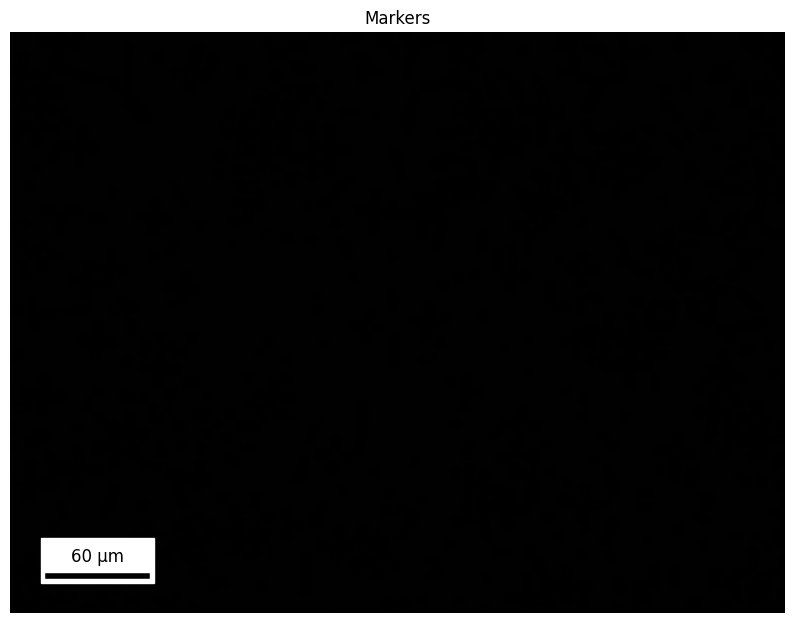

In [4]:
import cv2

sys.path.append("../../src/preprocessing")  # Ensure Python finds the module
import preprocessing

# Define preprocessing parameters (ADJUST HERE)
blur_kernel = (5,5)  # Adjust Gaussian blur strength
threshold_method = cv2.THRESH_BINARY_INV  # Choose thresholding method
threshold_value = 150  # Adjust threshold value for global thresholding
adaptive = True  # Use adaptive thresholding?
block_size = 15  # Block size for adaptive thresholding
C = 5  # Constant for adaptive thresholding

# Preprocess image
preprocessed_image = preprocessing.preprocess_image(raw_image, blur_kernel, threshold_method, 
                                                    threshold_value, adaptive, block_size, C)

image_with_scale_bar.display_image(preprocessed_image, title="Preprocessed Image")

# Define marker computation parameters (ADJUST HERE)
morph_kernel_size = (3,3)  # Morphological operations kernel size
dilation_iter = 3  # Number of dilation iterations
dist_transform_factor = 0.5  # Threshold factor for foreground detection
min_foreground_area = 100  # Minimum size of foreground components to keep

# Compute markers
markers = preprocessing.compute_markers(preprocessed_image, morph_kernel_size, dilation_iter, 
                                        dist_transform_factor, min_foreground_area)

image_with_scale_bar.display_image(markers, title="Markers")


## Image segmentation using watershed algorithm

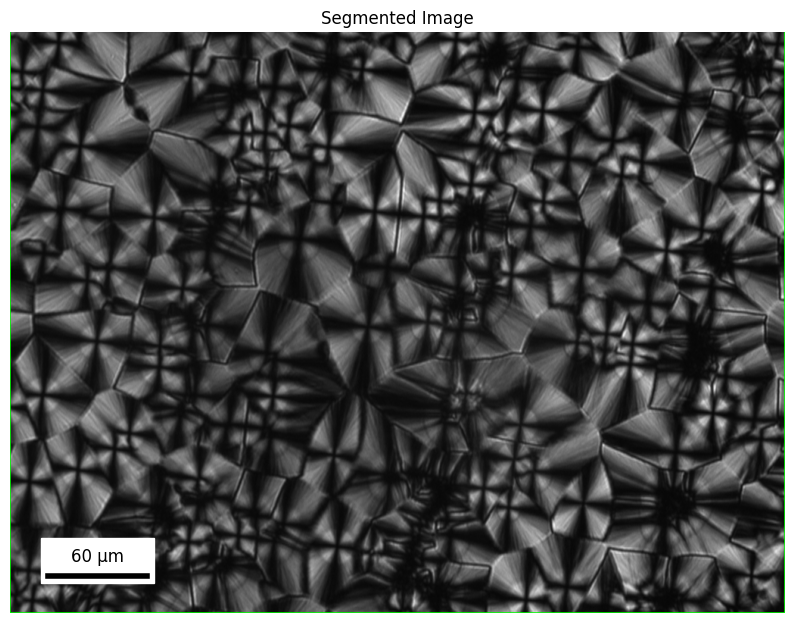

In [5]:
sys.path.append("../../src/segmentation")  # Ensure Python finds the module

import watershed_segmentation

# Applying watershed segmentation
segmented_image = watershed_segmentation.apply_watershed(raw_image, markers)

# Display the result
image_with_scale_bar.display_image(segmented_image, title="Segmented Image")